## Chapt 8. 차원의 저주 
## Curse of dimensionality

### 8.1 차원의 저주

#### 차원축소 장점: 훈련속도, 일부 성능 개선, 시각화와 통찰을 얻기에 유용
#### 차원축소 단점: 일반적 성능 하락, 작업 파이프라인 복잡, 유지 관리가 어려움

#### 차원의 저주: 고차원 데이터셋 = 희박한 상태, 거리가 매우 멀기 때문에 예측에 많은 외삽(extrapolation)을 해야 하고 예측이 불안정해짐 >> 과대적합 위험이 커짐

#### 훈련 샘플의 밀도를 높이기 위해 훈련 세트의 크기를 키운다. 하지만 차원 수가 커지면 요구되는 샘플이 기하급수로 증가, 충분한 샘플을 얻을 수 없음.

In [33]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 8.2 차원 축소를 위한 접근 방법
#### 투영, 매니폴드 학습

In [34]:
# 8.2.1 투영 

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m)*3*np.pi /2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise*np.random.randn(m)/2
X[:, 1] = np.sin(angles)*0.7 + noise*np.random.randn(m)/2
X[:, 2] = X[:, 0]*w1 + X[:, 1]*w2 + noise*np.random.randn(m)

In [35]:
# SVD 분해를 사용한 PCA
# m 샘플 개수, n 특성 개수

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

c1=Vt.T[:, 0]
c2=Vt.T[:, 1]

In [36]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [37]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [38]:
# d차원으로 투영하기
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

In [39]:
# 사이킷런 PCA, 데이터셋에서 평균 빼는 작업 대신 처리

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [40]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [41]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [42]:
# 데이터셋을 조금 다르게 해서 PCA 실행, 결과가 다르게 나오는 것은 일부 축이 반대로 바뀌는 정도. 
# SVD 방식을 사용하는 것과 동일한 투영결과를 만듬

np.allclose(X2D, -X2D_using_svd)

True

In [43]:
# PCA 2D 부분공간(평면)에 투영된 3D 포인트를 복원

X3D_inv = pca.inverse_transform(X2D)

In [44]:
# 투영단계에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 원본과 완전히 똑같지는 않다

np.allclose(X3D_inv, X)

False

In [45]:
# 재구성 오차

np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [46]:
# SVD 역변환

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [47]:
# 사이킷런 PCA 클래스는 자동으로 평균을 뺏던 것을 복원해줌, 두 방식의 재구성 오차가 동일하지 않음
# 평균을 빼면 동일한 재구성을 얻을 수 있음

np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [48]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [49]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [50]:
# 설명된 분산의 비율

pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [51]:
1 - pca.explained_variance_ratio_.sum()

# 2D로 투영했기 때문에  분산의 1.1%를 잃었다

0.011195535570688975

In [52]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [56]:
# 3D 화살표 

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [57]:
# 평면

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

ValueError: operands could not be broadcast together with shapes (1000,) (60,) 

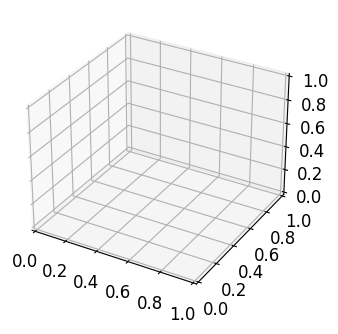

In [66]:
# 3D 데이터셋, 평면, 평면으로 투영
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
        pass
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: 맷플롯립 3.0.0 버전은 버그가 있기 때문에
# 3D 그래프를 잘 출력하지 못합니다.
# https://github.com/matplotlib/matplotlib/issues/12239 를 참조하세요.
# 따라서 최신 버전으로 업그레이드해야 합니다.
# 만약 업그레이드할 수 없다면 3D 그래프를 그리기 전에 다음 코드를 실행하세요:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

그림 저장 dataset_2d_plot


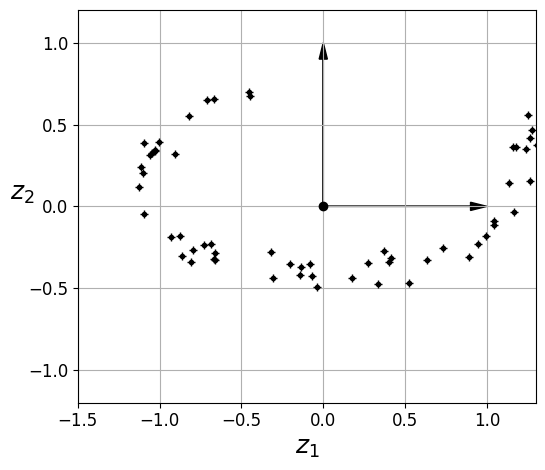

In [60]:
# 2D_porjection

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

In [61]:
# Swiss Roll Dataset
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise = 0.2, random_state=42)

그림 저장 swiss_roll_plot


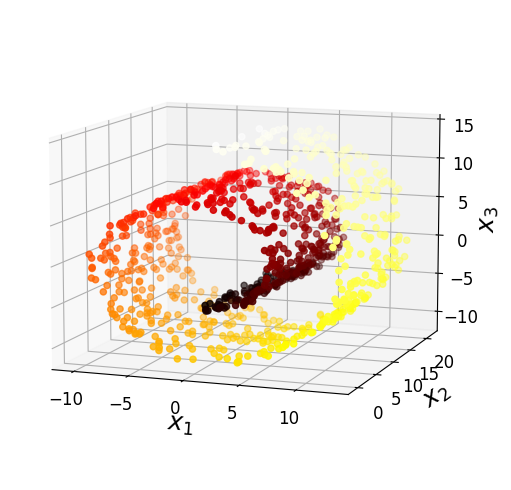

In [62]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

그림 저장 squished_swiss_roll_plot


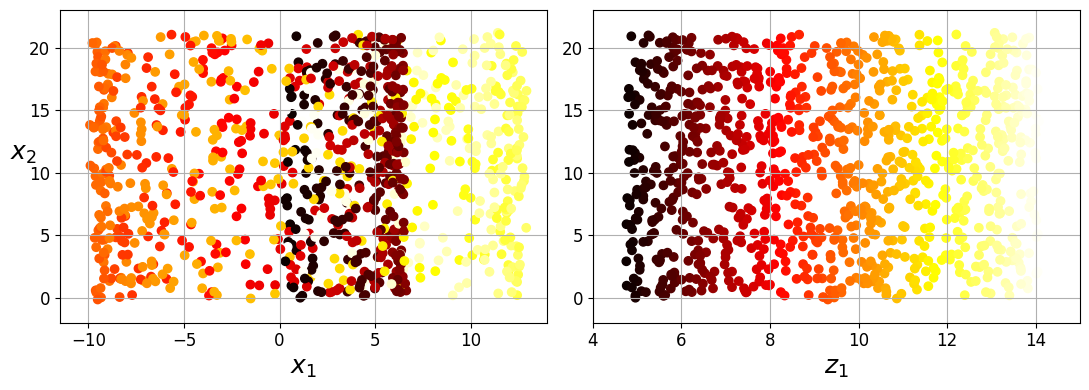

In [63]:
# projection

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

그림 저장 manifold_decision_boundary_plot1


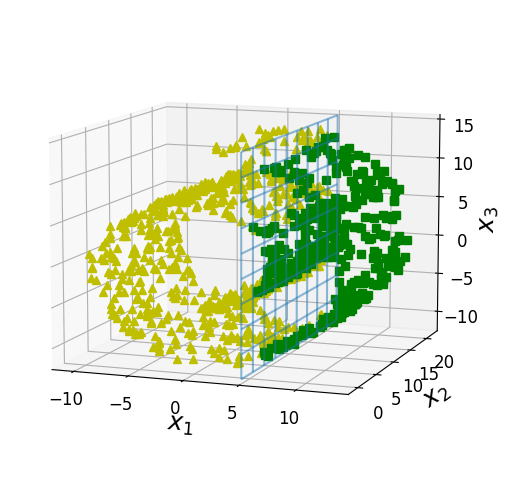

그림 저장 manifold_decision_boundary_plot2


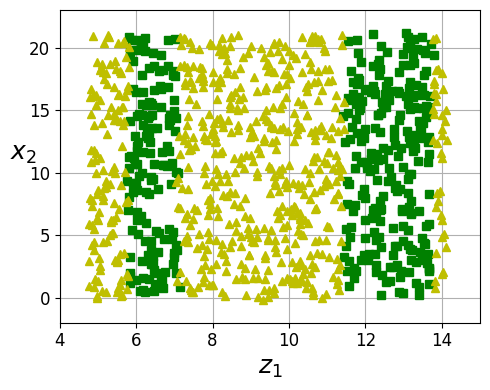

그림 저장 manifold_decision_boundary_plot3


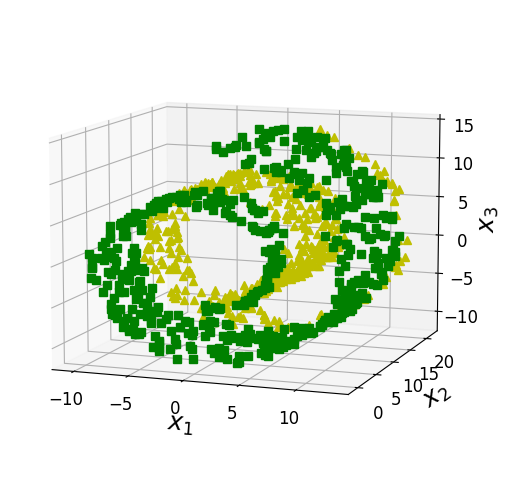

그림 저장 manifold_decision_boundary_plot4


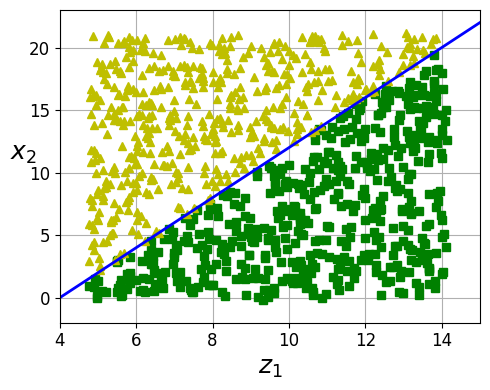

In [64]:
# Decision Boundary is not easily drawn in lower dimension

from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()


그림 저장 pca_best_projection_plot


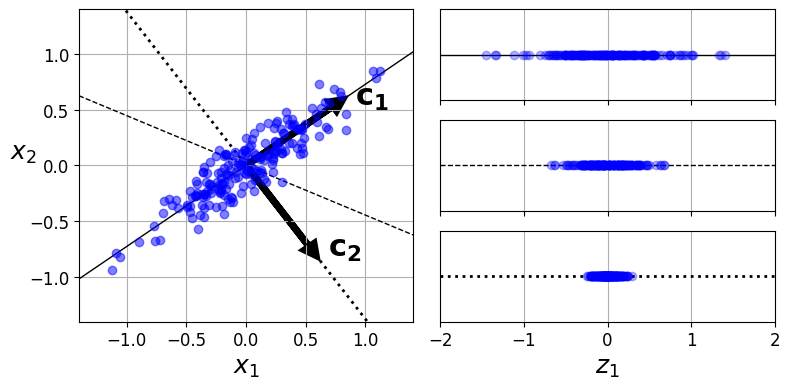

In [70]:
# 투영할 부분 공간 선택하기

angle = np.pi/5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m,2)/10
X = X.dot(np.array([[stretch, 0], [0, 1]]))
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2*np.pi/6), np.sin(angle -2*np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.subplot2grid((3,2), (0,0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

In [72]:
# 적절한 차원수 선택하기

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

In [73]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [74]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1

In [75]:
d

154

그림 저장 explained_variance


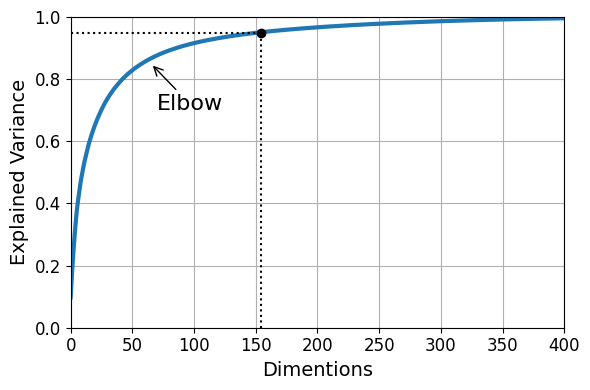

In [80]:
# 차원 수에 대한 함수로 나타낸 설명된 분산
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimentions")
plt.ylabel("Explained Variance")
plt.plot([d,d], [0, 0.95], "k:")
plt.plot([0,d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
            arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance")
plt.show()

In [83]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [84]:
pca.n_components_

154

In [85]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

### 8.3 PCA 주성분 분석
#### 분산 보존, 주성분, d차원으로 투영하기, 
#### 설명된 분산의 비율, 적절한 차원의 수 선택하기, 
#### 압축을 위한 PCA, 랜덤 PCA, 점진적 PCA

In [86]:
# 압축을 위한 PCA

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [87]:
# 분산의 95%가 유지된 MNIST 압축

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances)-1)//images_per_row+1
    
    n_empty = n_rows*images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size*size))], axis=0)
    
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    big_image = image_grid.transpose(0,2,1,3).reshape(n_rows*size, images_per_row*size)
    
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

그림 저장 mnist_compression_plot


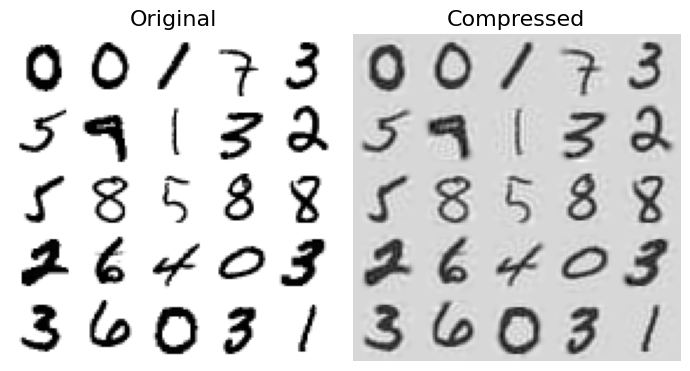

In [88]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [89]:
X_reduced_pca = X_reduced

In [90]:
# random PCA

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [92]:
# 점진적 PCA

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components =154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [93]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

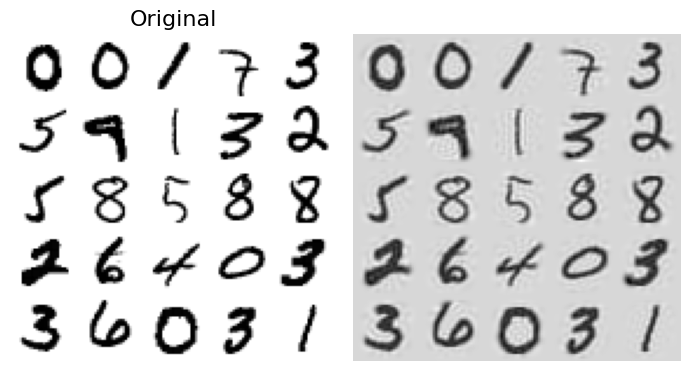

In [94]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.tight_layout()

In [95]:
X_reduced_inc_pca = X_reduced

In [96]:
# 일반  PCA와 점직전 PCA로 MNIST 데이터를 변환한 결과 비교 - 평균이 같은지 확인

np.allclose(pca.mean_, inc_pca.mean_)

True

In [97]:
# 결과가 완전히 동일하지는 않음

np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

In [98]:
# memmap() 구조를 만들고 MNIST 데이터를 복사합니다. 이는 일반적으로 별도의 프로그램에서 먼저 수행

filename = "my_mnist.data"
m,n = X_train.shape

X_mm = np.memmap(filename, dtype = 'float32', mode = 'write', shape = (m,n))
X_mm[:] = X_train


In [99]:
del X_mm

In [101]:
X_mm = np.memmap(filename, dtype="float32", mode = "readonly", shape = (m,n))

batch_size = m//n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size = batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [102]:
# 시간 복잡도
rnd_pca = PCA(n_components=154, svd_solver = "randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [103]:
import time
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver = "full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver = "randomized")
    
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("      {}: {: .1f} 초".format(pca.__class__.__name__, t2-t1))

n_components = 2
      PCA:  3.5 초
      IncrementalPCA:  19.0 초
      PCA:  1.1 초
n_components = 10
      PCA:  3.3 초
      IncrementalPCA:  19.4 초
      PCA:  1.5 초
n_components = 154
      PCA:  3.3 초
      IncrementalPCA:  24.4 초
      PCA:  2.8 초


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

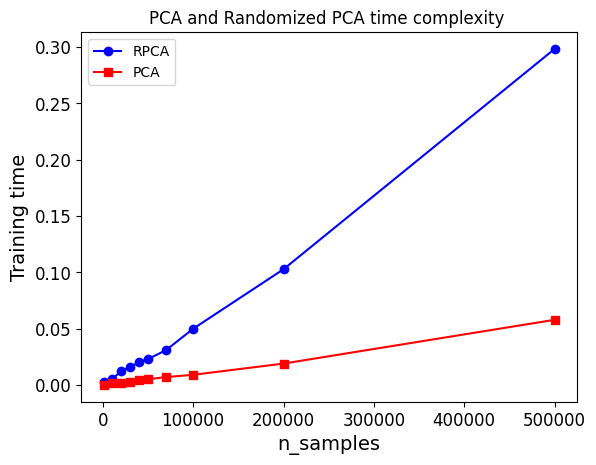

In [104]:
# 샘플 수 바꾸어 일반과 랜던 비교

times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

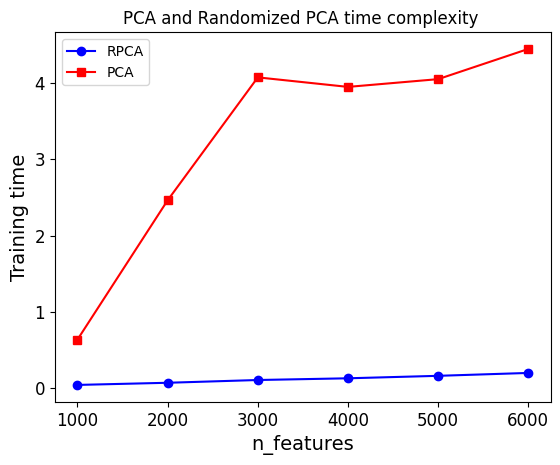

In [105]:
# 특성 개수 다르게 해서 성능 비교

times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

### 8.4 커널 PCA
#### 커널 선택과 하이퍼파라미터 튜닝

In [106]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [107]:
from sklearn.decomposition import KernelPCA # kernmalPCA 불러오기

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

그림 저장 kernel_pca_plot


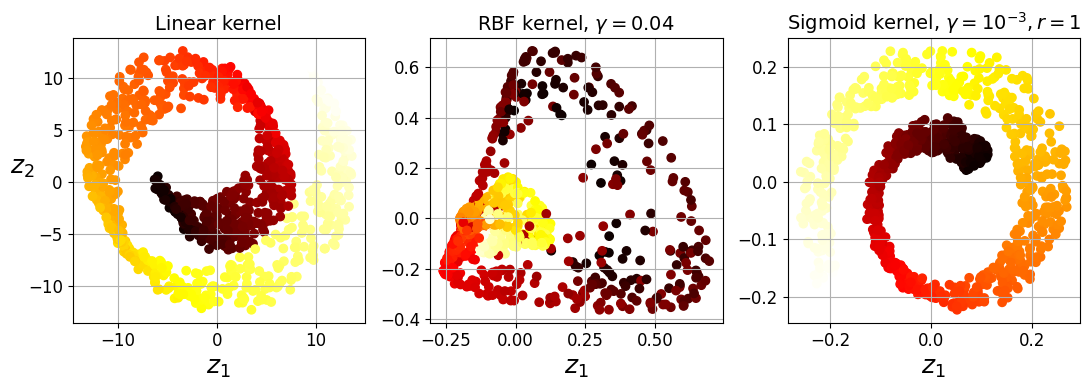

In [108]:
# 여러가지 커널의  kPCA를 사용해 2D로 축소시킨 스위스 롤

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

그림 저장 preimage_plot


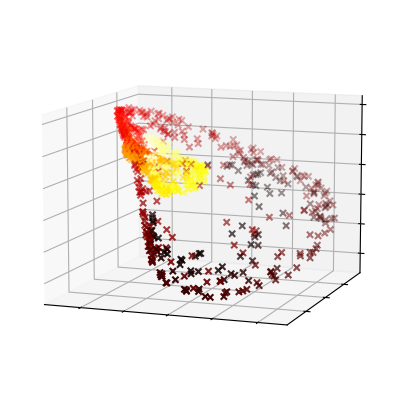

In [109]:
# 커널 PCA와 재구성 원상 오차

plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

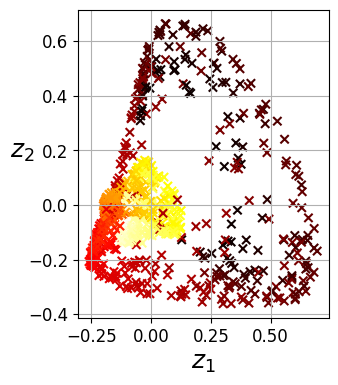

In [110]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [111]:
# 커널과 하이퍼파라미터 튜닝

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [112]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [113]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [114]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

### 8.5 LLE 지역 선형 임베딩 Locally Linear Embedding

In [115]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [116]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

그림 저장 lle_unrolling_plot


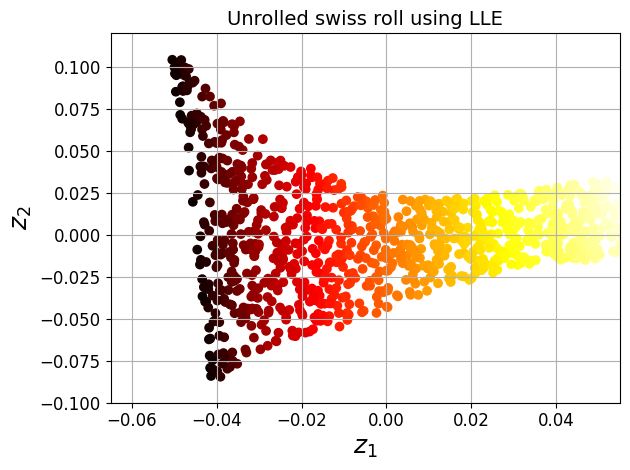

In [117]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

### 8.6 다른 차원 축소 기법
#### 랜덤 투영, 다차원 스케일링 MDS, Isomap, t-SNE, 선형판별분석 LDA

In [118]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [119]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [120]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [121]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]

lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

그림 저장 other_dim_reduction_plot


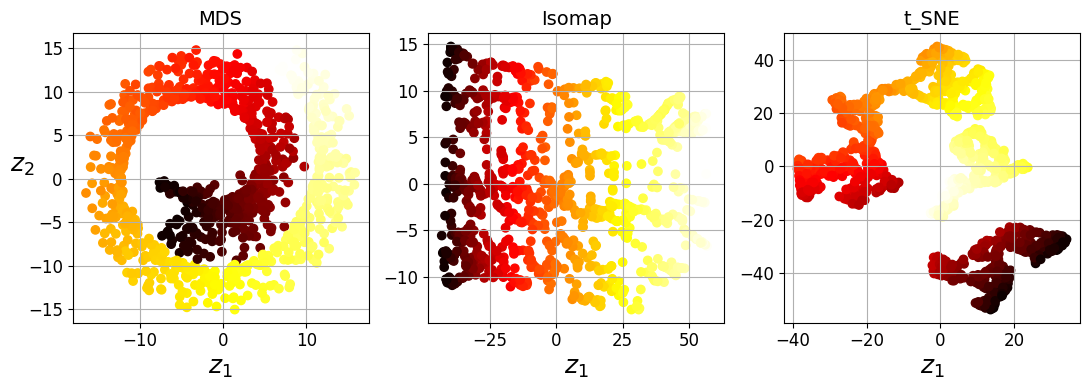

In [123]:
# 여러가지 기법을 사용해 스위스 롤을 2D로 축소하기

titles = ["MDS", "Isomap", "t_SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                    (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
save_fig("other_dim_reduction_plot")
plt.show()

### 연습문제

#### 9
#### MNIST 데이터 로드, 훈련 세트(60000)와 테스트 세트(10000)로 분할
#### 랜덤 포레스트 분류기 훈련, 시간 측정, 테스트 세트로 모델 평가
#### PCA 사용해 분산이 95% 되도록 차원 축소
#### 축소된 데이터셋에 랜덤포레스트 훈련, 시간 측정, 테스트 세트로 모델 평가
#### 이전 분류기와 비교

In [124]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [125]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [126]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [127]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 29.65s


In [128]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [129]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [130]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [131]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 66.08s


In [132]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

In [133]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [134]:

print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 13.34s


In [135]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.9255

In [136]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [137]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 4.85s


In [138]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

In [ ]:
# 램덤 포레스트와 소프트 맥스 분류기를 사용하여 일반 데이터셋과 축소된 데이터셋을 훈련하여 성능 평가
# PCA가 속드를 아주 빠르게 만들어 주지만 항상 그런 것은 아니다

#### 10
#### t_SNE 알고리즘 사용 MNIST 데이터셋 2착원으로 축소
#### 맷플롯립으로 그래프 그리기
#### 이미지의 타킷 클래스 마다 10가지 색상으로 나타낸 산점도 그리기
#### 산점도의 각 포인트를 상응하는 샘플의 클래스로 바꾸거나 숫자 이미지 자체의 크기를 줄여서 그리기
#### 분리된 숫자의 굽지을 시각화
#### PCA, LLE,  MDS 차원 축소 알고리즘 적용, 시각화, 결과 비교

In [139]:

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [140]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


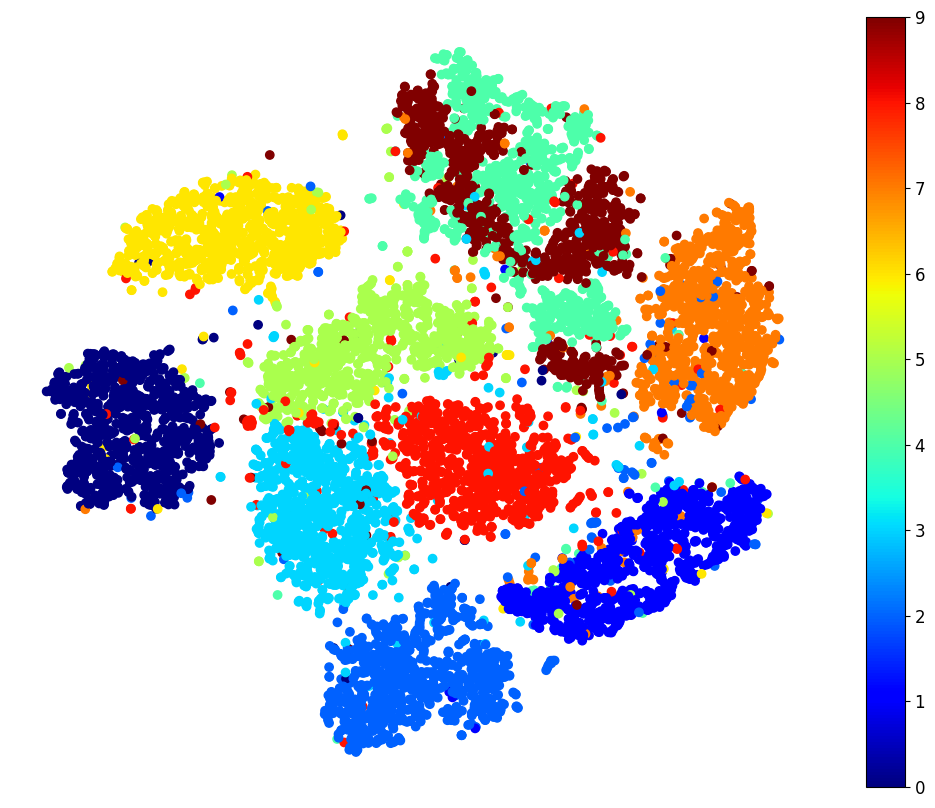

In [141]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

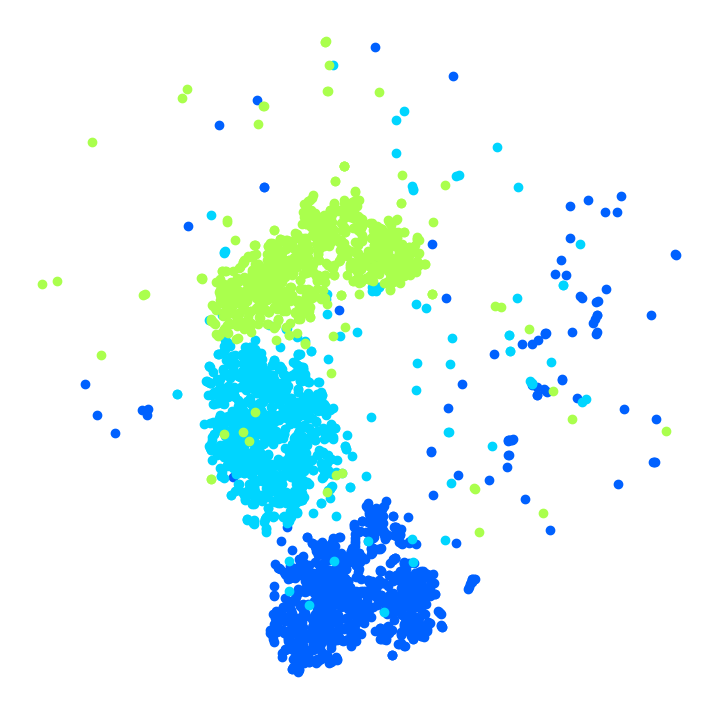

In [142]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [144]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


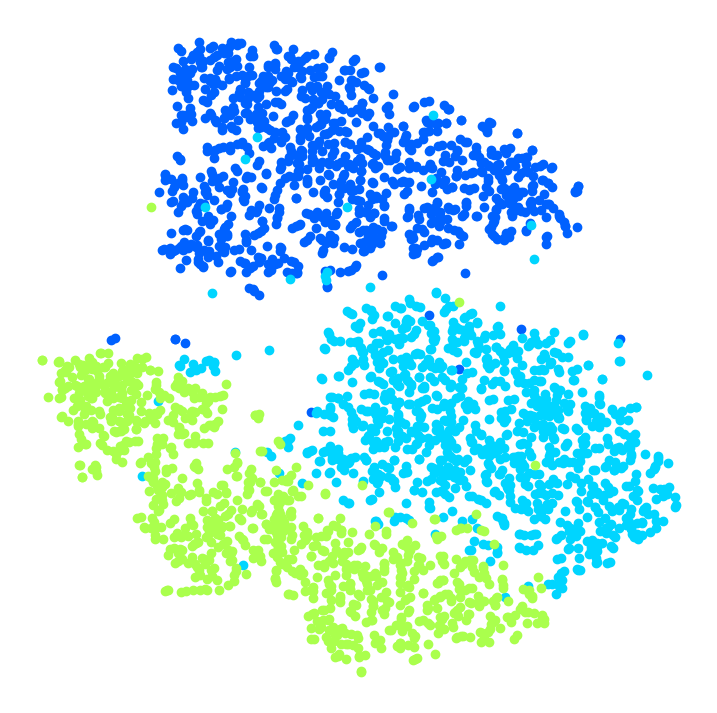

In [145]:

plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [146]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1 사이로 만듭니다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 그릴 숫자의 좌표 목록을 만듭니다.
    # 반복문 아래에서 `if` 문장을 쓰지 않기 위해 시작할 때 이미 그래프가 그려져 있다고 가정합니다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 이해하기 쉽습니다.
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # 현재 그래프의 축을 가져옵니다.
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)
                
                

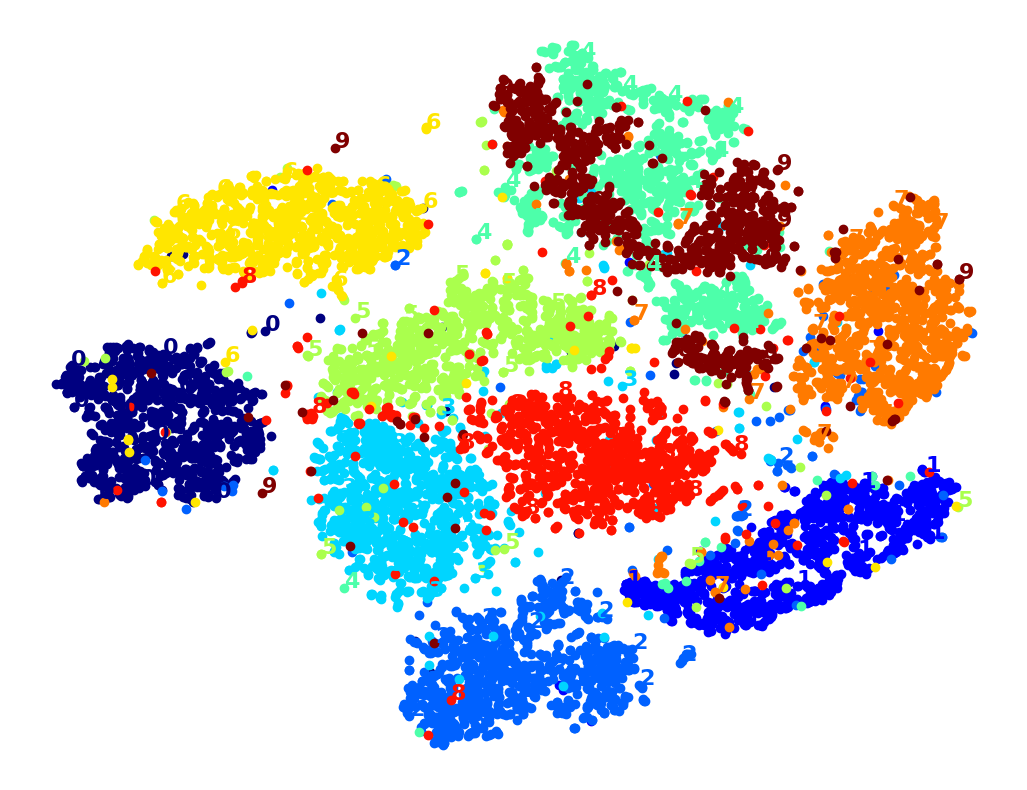

In [147]:
plot_digits(X_reduced, y)

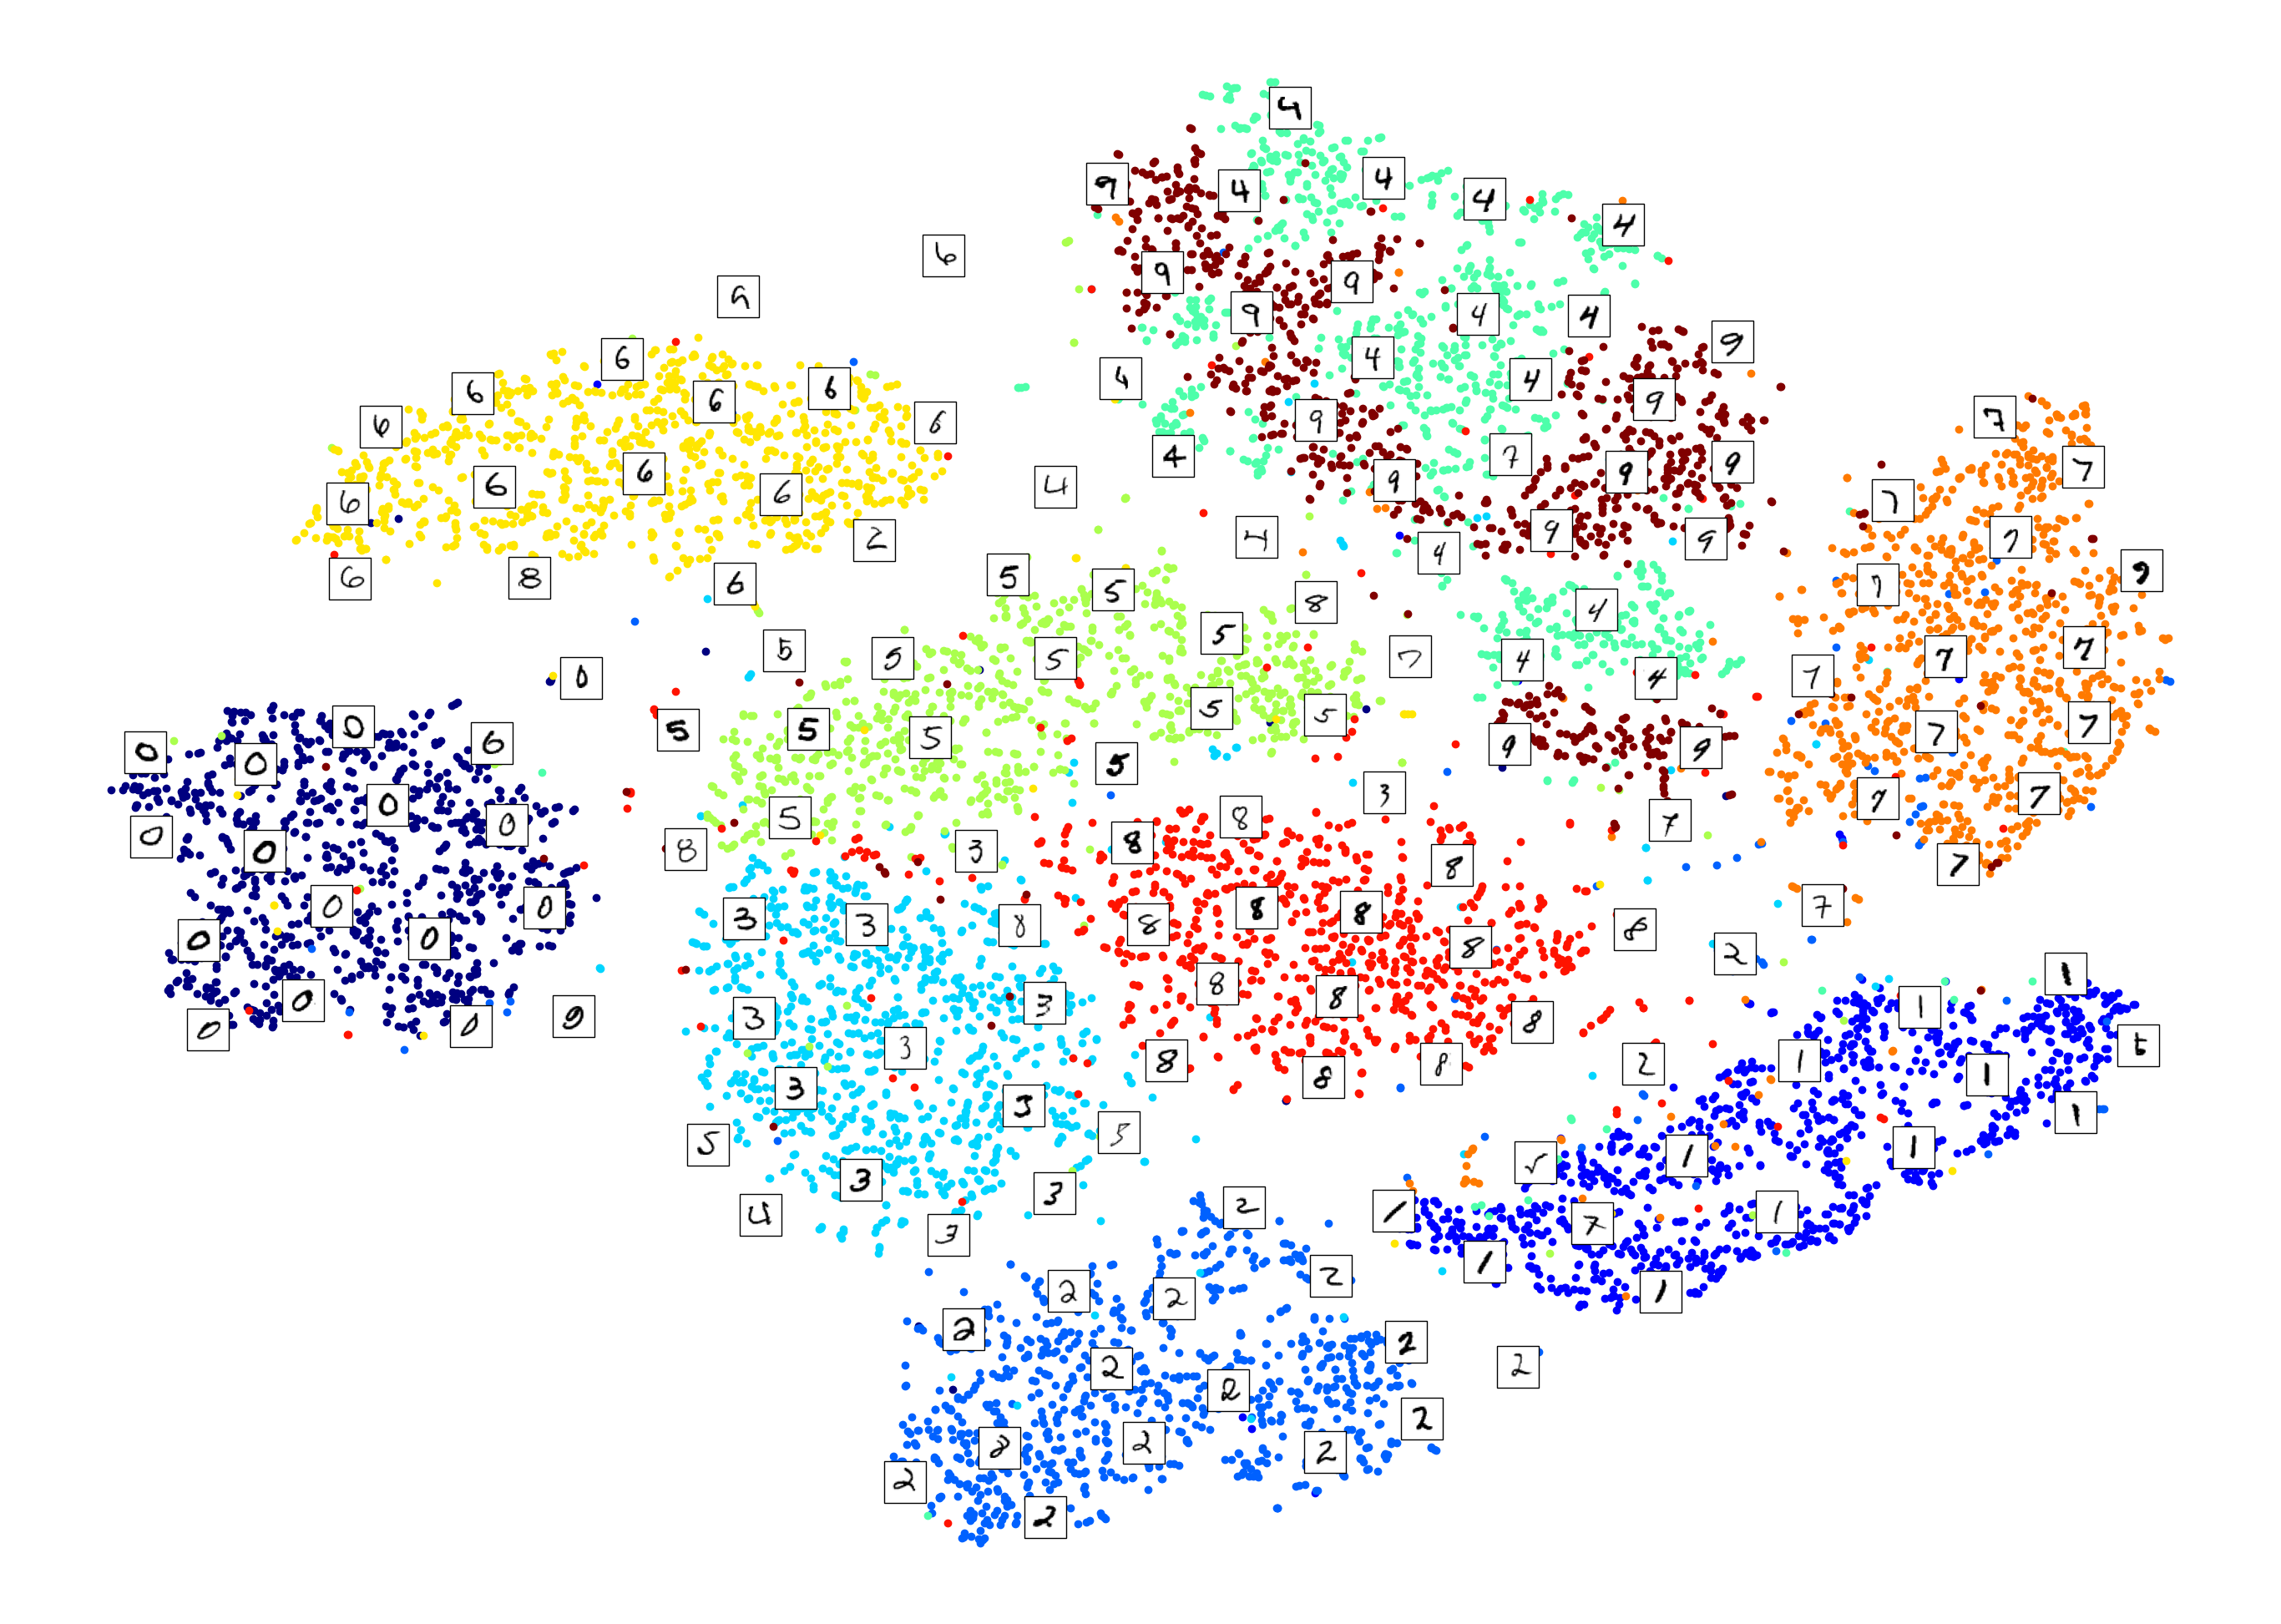

In [148]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

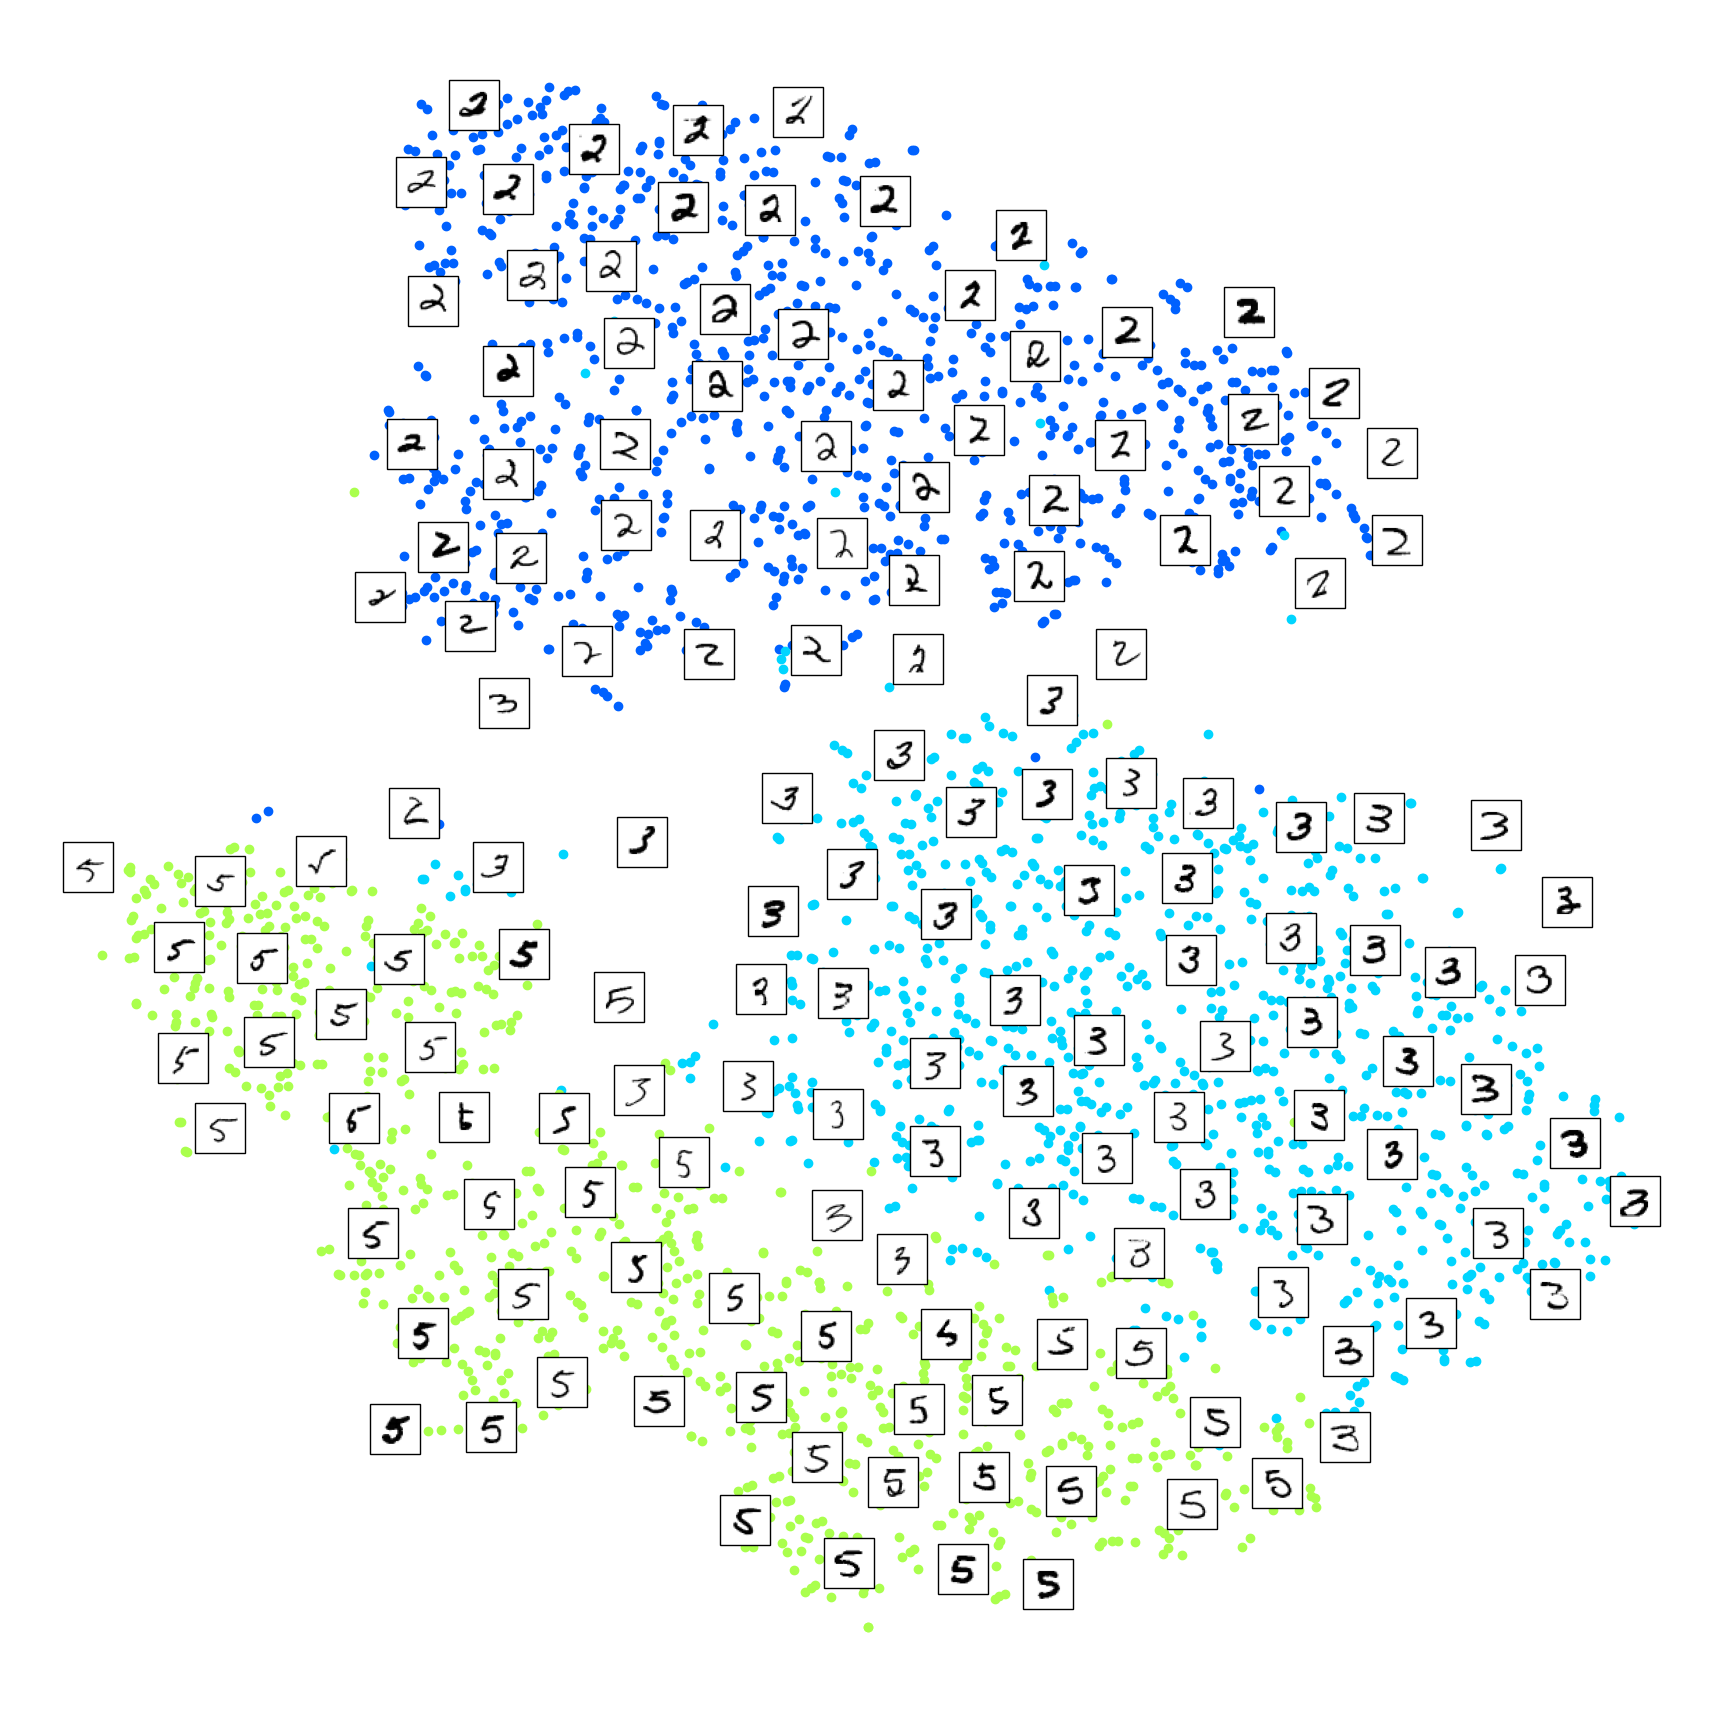

In [149]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA 시간: 0.2s.


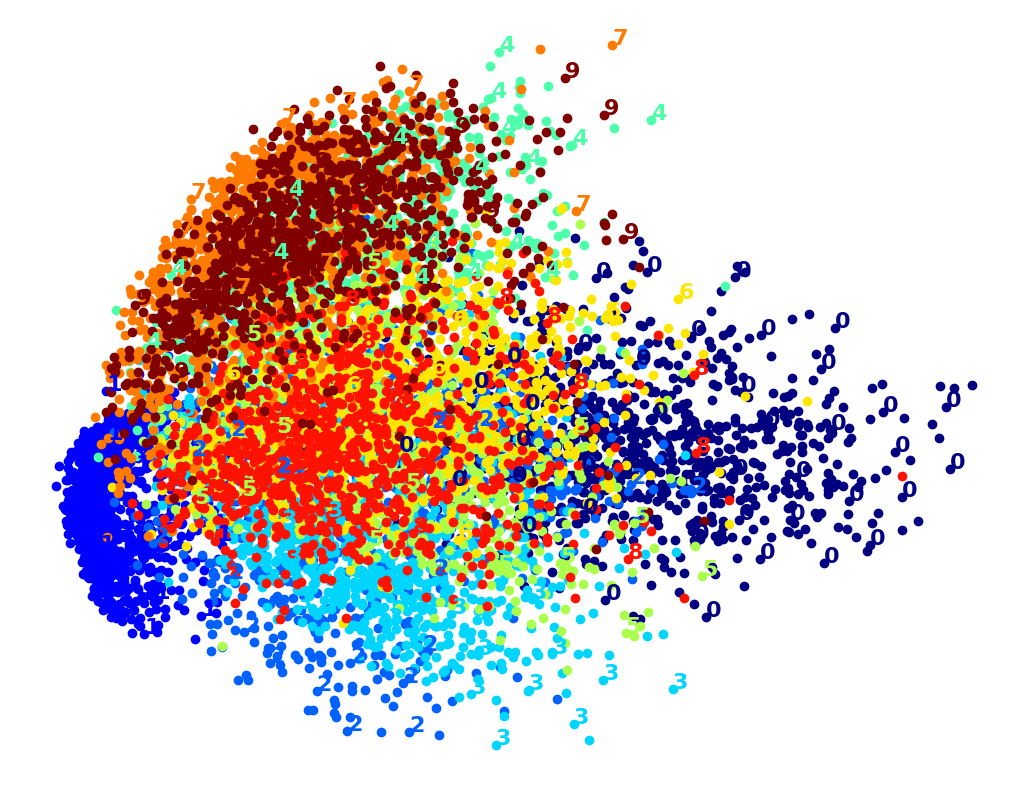

In [150]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

LLE 시간: 27.9s.


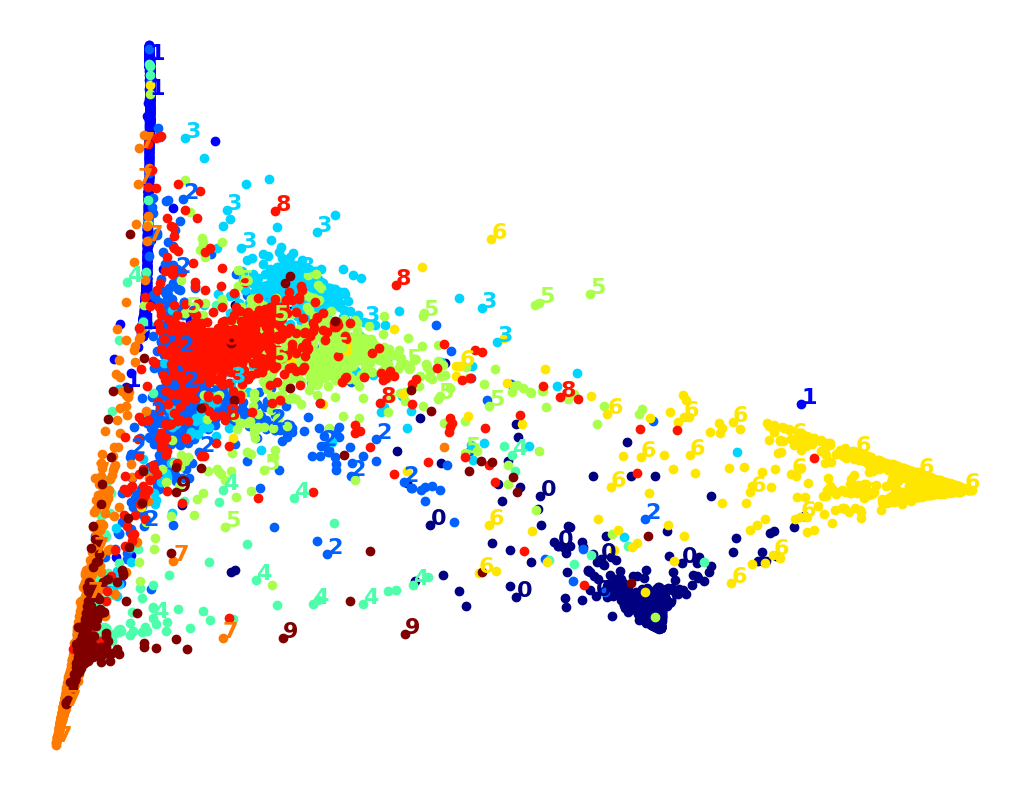

In [151]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA+LLE 시간: 30.5s.


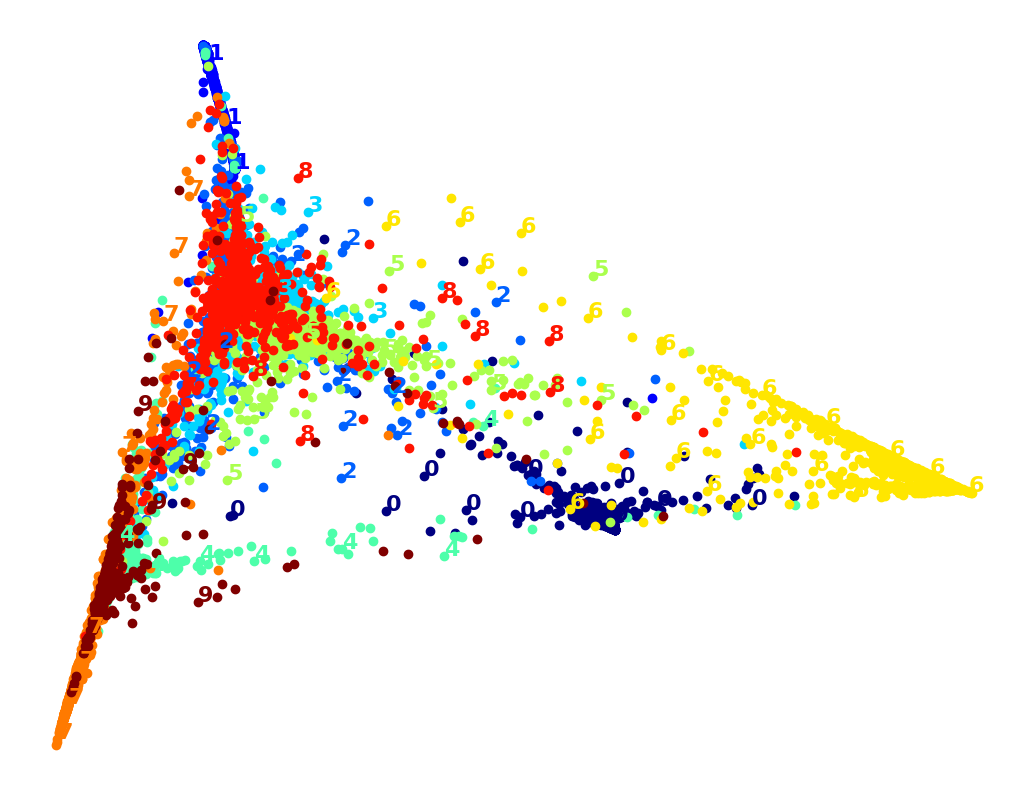

In [152]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

MDS 시간 99.7s (on just 2,000 MNIST images instead of 10,000).


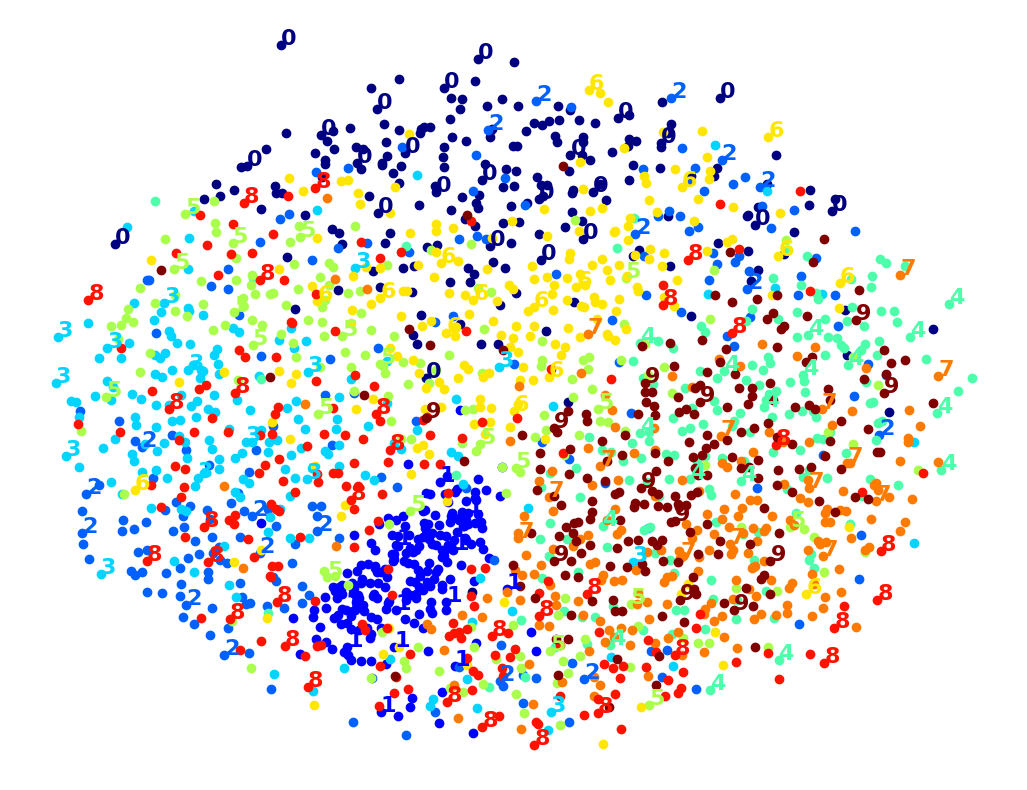

In [153]:

from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 시간 {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

PCA+MDS 시간 99.7s (on 2,000 MNIST images).


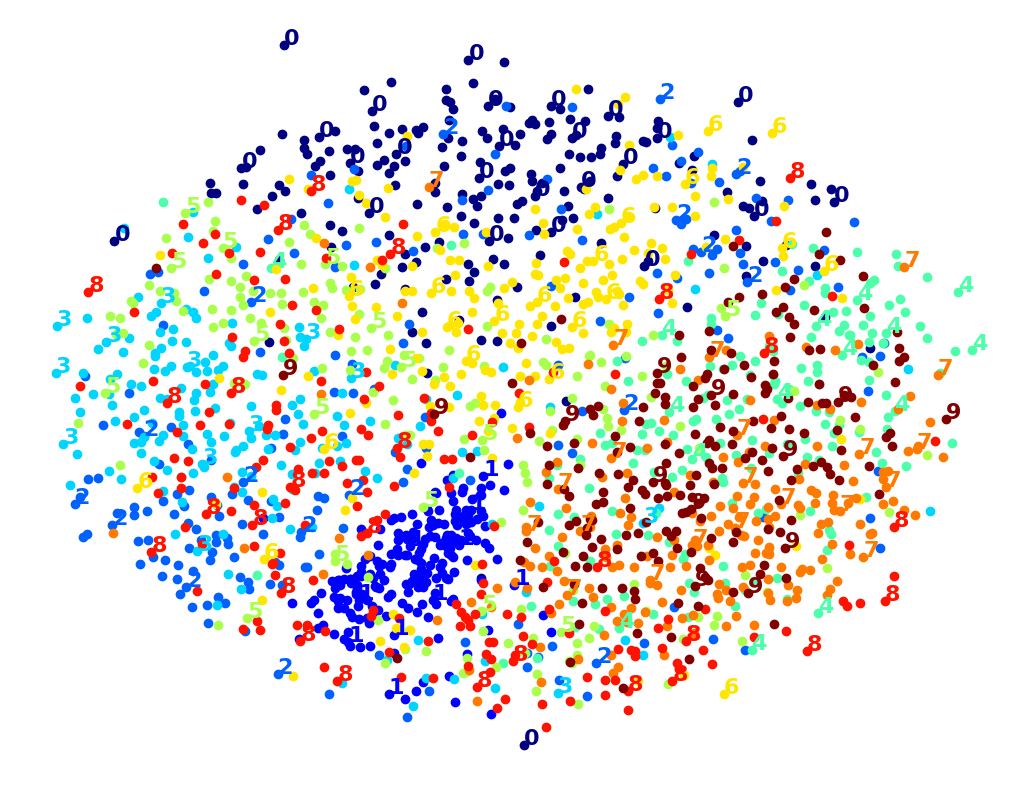

In [154]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS 시간 {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

LDA 시간 1.2s.


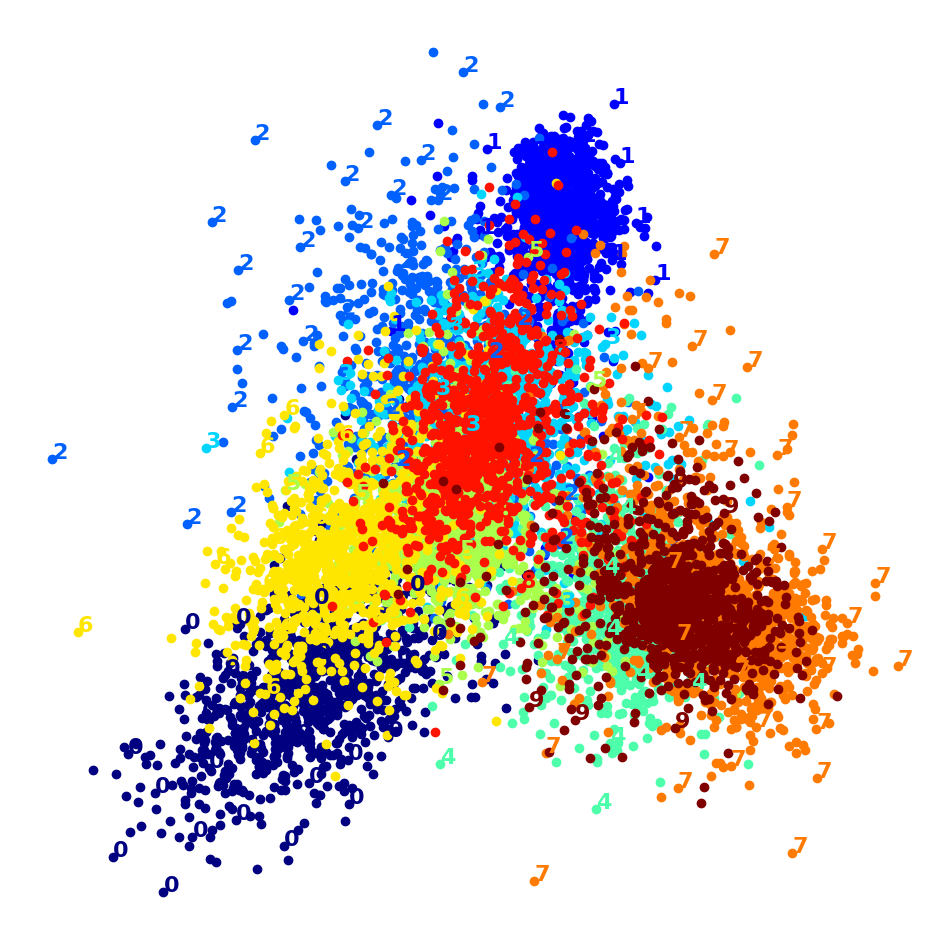

In [155]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE 시간 24.7s.


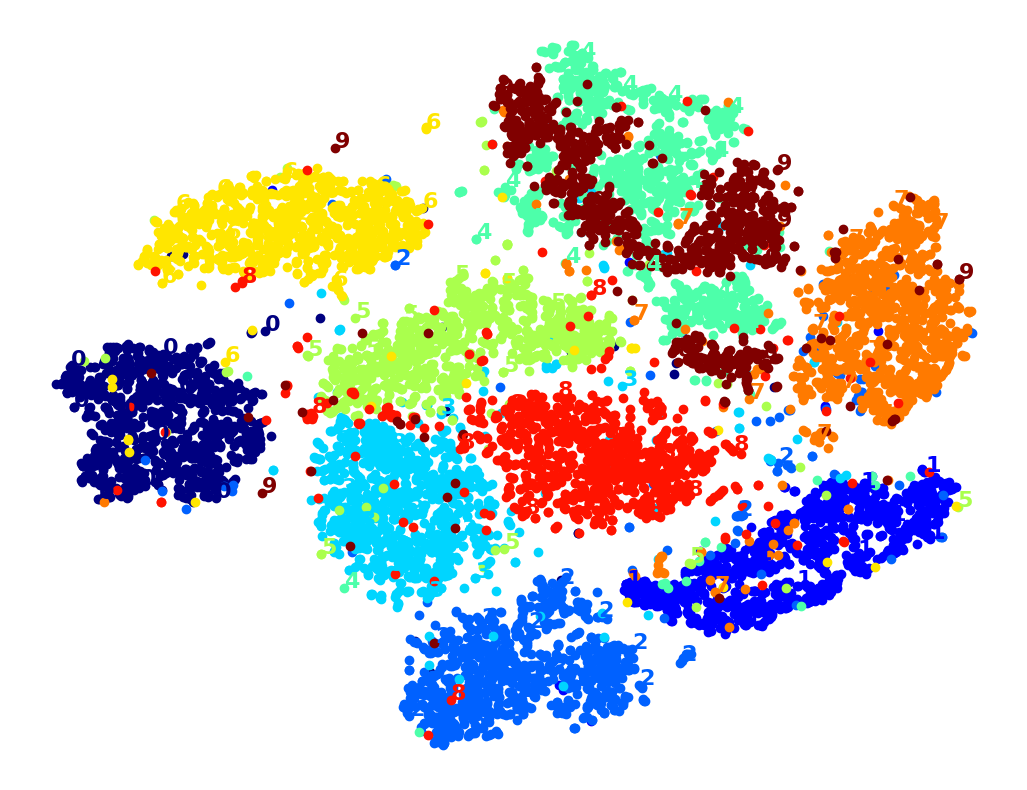

In [156]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Python\Venv\Py37_ML\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


PCA+t-SNE 시간 25.2s.


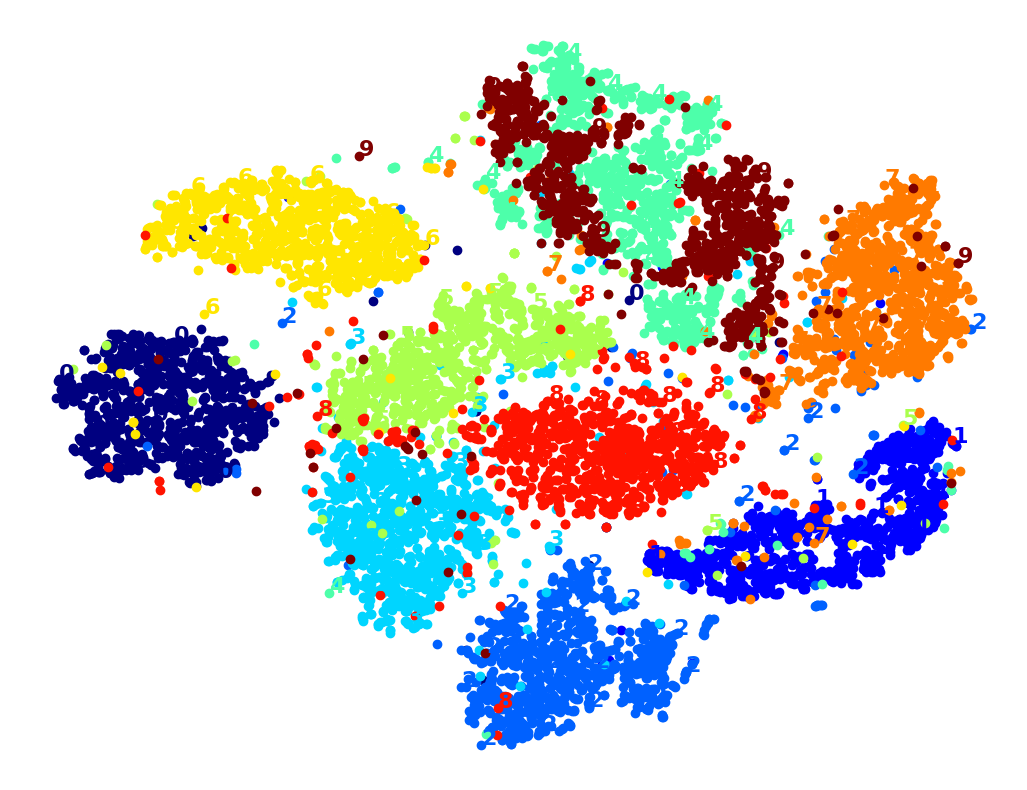

In [157]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

### Practice_PCA_Reconstruction

In [171]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [180]:
glory = imread("theglory.jpg")

In [181]:
print(glory.shape)

(1036, 700, 3)


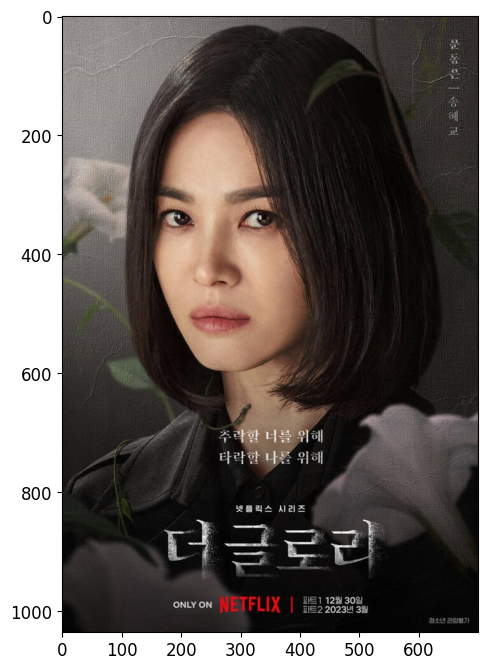

In [182]:
plt.figure(figsize=[12,8])
plt.imshow(glory)

In [186]:
# greyscalling

image_sum = glory.sum(axis=2)
print(image_sum.shape)

(1036, 700)


In [187]:
new_image = image_sum/image_sum.max()
print(new_image.max())

1.0


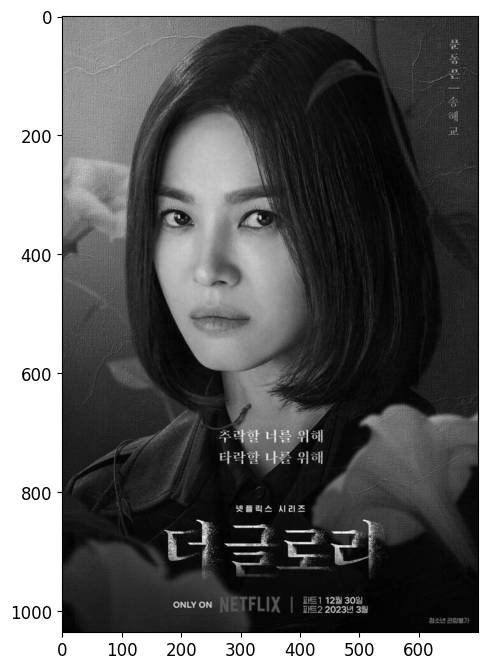

In [188]:
plt.figure(figsize=[12,8])
plt.imshow(new_image, cmap=plt.cm.gray)

In [191]:
from sklearn.decomposition import PCA, IncrementalPCA

pca = PCA()
pca.fit(new_image)

PCA()

In [193]:
# Getting the cumulative variance
 
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
 

In [196]:
# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))

Number of components explaining 95% variance: 27


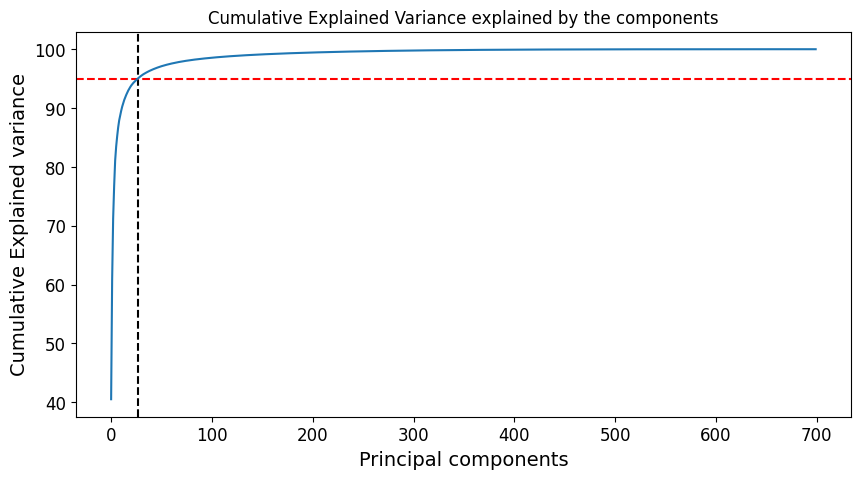

In [197]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [198]:
#Reconstructing using Inverse Transform
ipca = IncrementalPCA(n_components=k)
image_recon = ipca.inverse_transform(ipca.fit_transform(new_image))

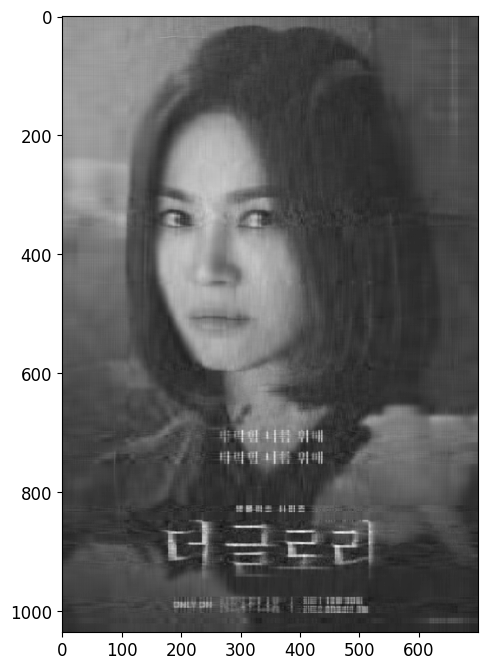

In [199]:
# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

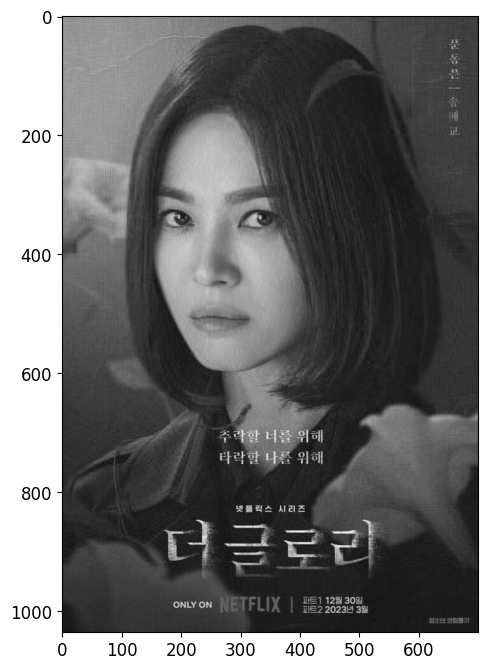

In [200]:
# Function to reconstruct and plot image for a given number of components
 
def plot_at_k(k):
    ipca = IncrementalPCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(new_image))
    plt.imshow(image_recon,cmap = plt.cm.gray)
    
k = 150
plt.figure(figsize=[12,8])
plot_at_k(100)

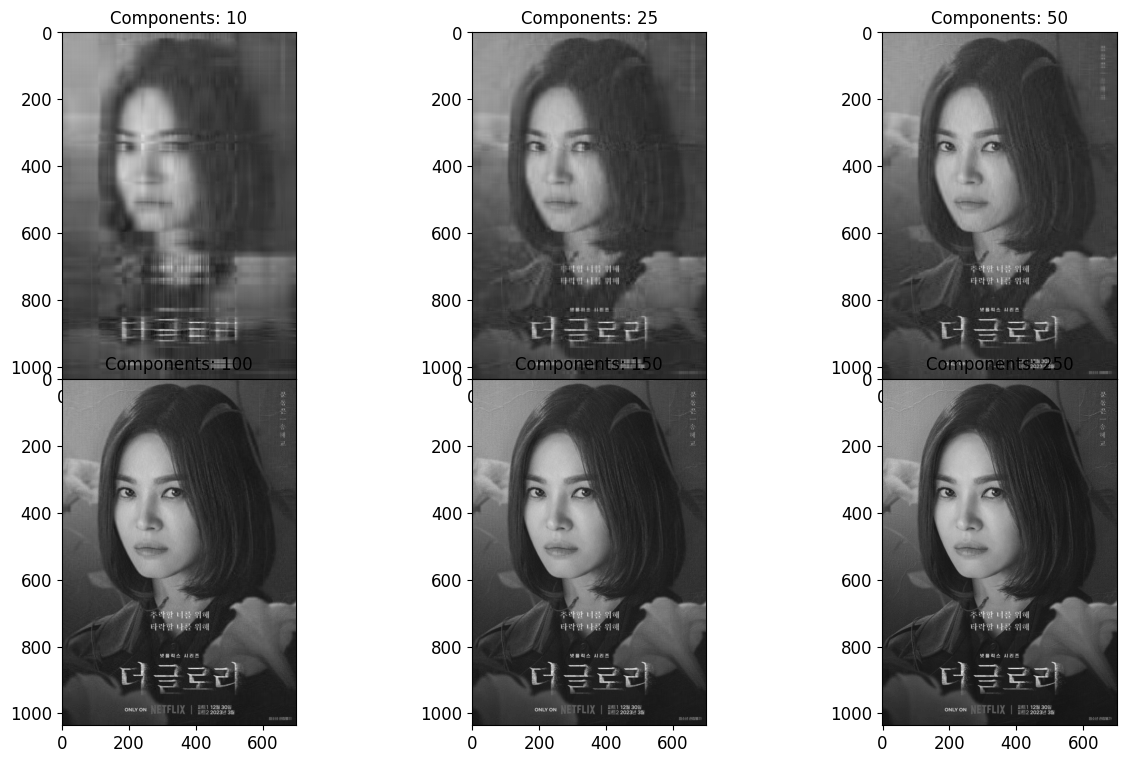

In [201]:
#setting different amounts of K
ks = [10, 25, 50, 100, 150, 250]
 
plt.figure(figsize=[15,9])
 
for i in range(6):
    plt.subplot(2,3,i+1)
    plot_at_k(ks[i])
    plt.title("Components: "+str(ks[i]))
 
plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()